SPX Data Columns: Index(['date', 'spx'], dtype='object')
Static Options Data Columns: Index(['leg', 'target_expiration', 'target_strike', 'ask_price', 'bid_price',
       'old_ask_price', 'old_bid_price'],
      dtype='object')
Daily Options Data Columns: Index(['date', 'leg_1_ask', 'leg_1_bid', 'leg_2_ask', 'leg_2_bid', 'leg_3_ask',
       'leg_3_bid'],
      dtype='object')
Value at Risk (VaR) at 95.0% confidence level: -0.0197
Expected Shortfall (ES): -0.0328


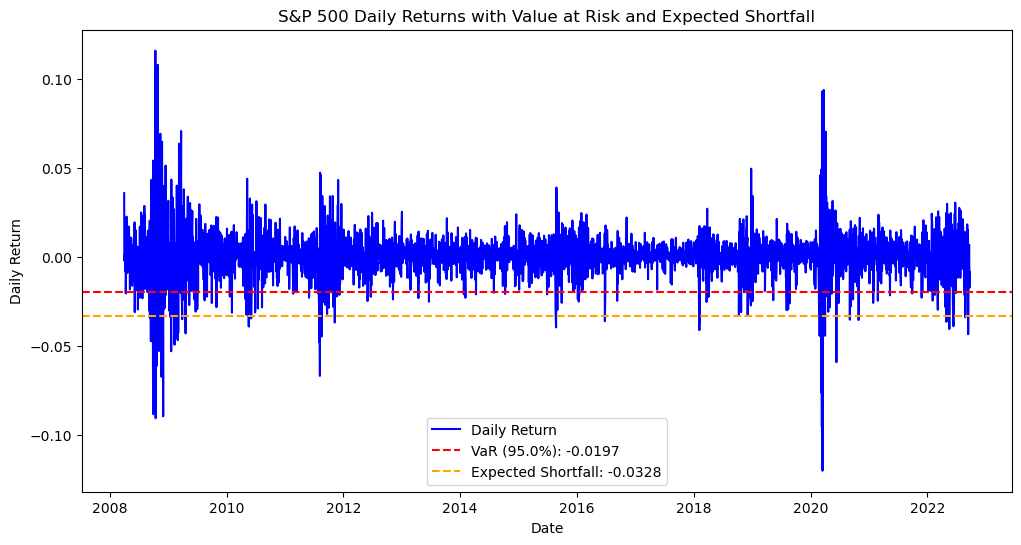

Hedge position added on 2009-01-15 00:00:00: Cost = 9.4, Expiration = 1970-01-01T00:00:00.000000017, Units = 0.05319148936170213
Hedge position added on 2010-01-14 00:00:00: Cost = 1.8, Expiration = 1970-01-01T00:00:00.000000008, Units = 0.2777777777777778
Hedge position added on 2011-01-20 00:00:00: Cost = 2.2, Expiration = 1970-01-01T00:00:00.000000008, Units = 0.22727272727272727
Hedge position added on 2012-01-19 00:00:00: Cost = 1.25, Expiration = 1970-01-01T00:00:00.000000011, Units = 0.4
Hedge position added on 2013-01-17 00:00:00: Cost = 1.75, Expiration = 1970-01-01T00:00:00.000000007, Units = 0.2857142857142857
Hedge position added on 2014-01-16 00:00:00: Cost = 3.3, Expiration = 1970-01-01T00:00:00.000000009, Units = 0.15151515151515152
Hedge position added on 2015-01-15 00:00:00: Cost = 15.1, Expiration = 1970-01-01T00:00:00.000000015, Units = 0.033112582781456956
Hedge position added on 2016-01-14 00:00:00: Cost = 21.0, Expiration = 1970-01-01T00:00:00.000000015, Units = 0

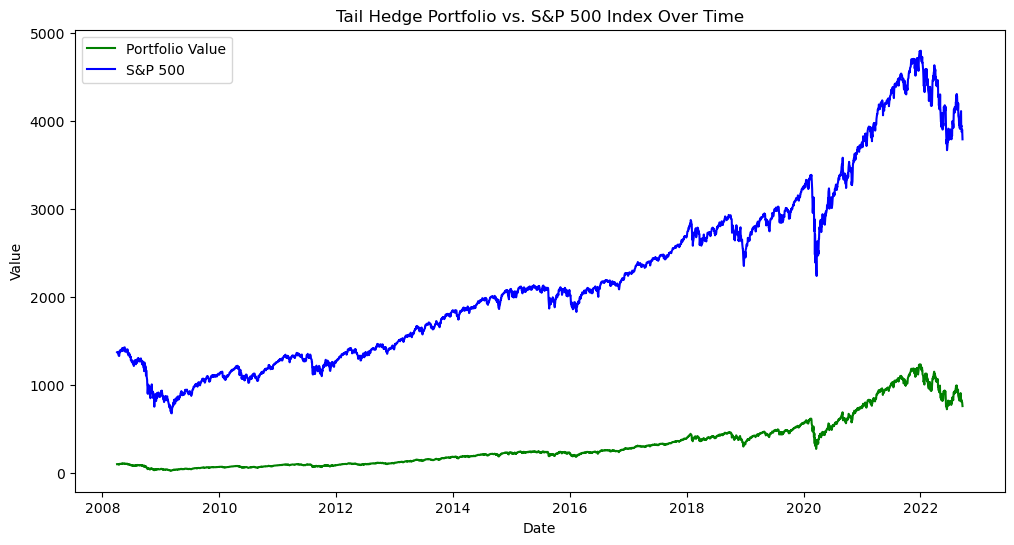

In [7]:
import pandas as pd  # Pandas for data frames and data manipulation
import numpy as np  # NumPy for numerical operations
import matplotlib.pyplot as plt  # Matplotlib for plotting graphs
from datetime import datetime, timedelta  # DateTime for handling date and time objects

spx = pd.read_csv("spx.csv")  # Load S&P 500 index data into a DataFrame
options_static = pd.read_csv("spx_selected_option.csv")  # Load static options data (contract details)
options_daily = pd.read_csv("spx_selected_option_daily_price.csv")  # Load daily options price data

# Display column names from each DataFrame for verification and to identify relevant columns
print("SPX Data Columns:", spx.columns)
print("Static Options Data Columns:", options_static.columns)
print("Daily Options Data Columns:", options_daily.columns)

# Dynamically identify column names to avoid hardcoding, ensuring code robustness
date_column_spx = 'date' if 'date' in spx.columns else spx.columns[0]  # Column for dates in SPX data
spx_price_column = 'spx' if 'spx' in spx.columns else spx.columns[1]  # Column for SPX prices
expiration_column_static = 'target_expiration' if 'target_expiration' in options_static.columns else options_static.columns[1]  
# Expiration date in static options data
expiration_column_daily = 'target_expiration' if 'target_expiration' in options_daily.columns else options_daily.columns[1] 
# Expiration date in daily options data
date_column_daily = 'date' if 'date' in options_daily.columns else options_daily.columns[0]  
# Dates in daily options data
ask_price_column = 'ask_price' if 'ask_price' in options_daily.columns else options_daily.columns[-1]  
# Ask price column in daily options data

# Convert date columns from strings to datetime objects for accurate date manipulations
spx[date_column_spx] = pd.to_datetime(spx[date_column_spx])  # Convert SPX date column to datetime format
options_static[expiration_column_static] = pd.to_datetime(options_static[expiration_column_static])  
# Convert static options expiration dates
options_daily[expiration_column_daily] = pd.to_datetime(options_daily[expiration_column_daily], errors='coerce')  
# Convert daily options expiration dates, coerce errors to NaT (Not a Time)
options_daily[date_column_daily] = pd.to_datetime(options_daily[date_column_daily])  
# Convert daily options dates

# **Step 1: Understand and Measure Tail Risk on S&P 500 Index**

# Calculate daily returns for the S&P 500 index
spx['daily_return'] = spx[spx_price_column].pct_change()  # Compute daily percentage change in SPX prices
spx.dropna(inplace=True)  # Remove the first row (NaN return) after percentage change calculation

# Calculate Value at Risk (VaR) and Expected Shortfall (ES) to assess tail risk
confidence_level = 0.95  # Set the confidence level at 95%
VaR = spx['daily_return'].quantile(1 - confidence_level)  # Calculate the VaR at the specified confidence level
ES = spx[spx['daily_return'] <= VaR]['daily_return'].mean()  # Compute ES as the average of returns below the VaR threshold

# Display the calculated VaR and ES values
print(f"Value at Risk (VaR) at {confidence_level*100}% confidence level: {VaR:.4f}")
print(f"Expected Shortfall (ES): {ES:.4f}")

# Plot SPX Daily Returns along with VaR and ES for visualization
plt.figure(figsize=(12, 6))  # Set the figure size for the plot
plt.plot(spx[date_column_spx], spx['daily_return'], label='Daily Return', color='blue')  
# Plot daily returns over time
plt.axhline(VaR, color='red', linestyle='--', label=f'VaR ({confidence_level*100}%): {VaR:.4f}') 
# Plot horizontal line for VaR
plt.axhline(ES, color='orange', linestyle='--', label=f'Expected Shortfall: {ES:.4f}')  # Plot horizontal line for ES
plt.xlabel('Date')  # Label for x-axis
plt.ylabel('Daily Return')  # Label for y-axis
plt.title('S&P 500 Daily Returns with Value at Risk and Expected Shortfall')  # Title of the plot
plt.legend()  # Display legend
plt.show()  # Render the plot

# **Define utility functions to support the hedging strategy**

def get_third_friday(year, month):
    """
    Calculate the date of the third Friday for a given month and year.

    Parameters:
        year (int): The year for which to find the third Friday.
        month (int): The month for which to find the third Friday.

    Returns:
        datetime: The date of the third Friday of the specified month and year.
    """
    first_day = datetime(year, month, 1)  # Get the first day of the month
    # Calculate the first Friday of the month
    first_friday = first_day + timedelta(days=(4 - first_day.weekday() + 7) % 7)
    # Add two weeks to get to the third Friday
    return first_friday + timedelta(weeks=2)

def is_business_day_before_third_friday(date):
    """
    Check if a given date is the business day before the third Friday of its month.

    Parameters:
        date (datetime): The date to check.

    Returns:
        bool: True if the date is the business day before the third Friday, False otherwise.
    """
    third_friday = get_third_friday(date.year, date.month)  # Get the third Friday of the month
    business_day_before = third_friday - timedelta(days=1)  # Calculate the day before the third Friday
    return date == business_day_before  # Return True if date matches

# **Step 2: Design Tail Hedge Strategy**

# Initialize portfolio variables
start_cash = 100  # Starting cash amount in the portfolio
portfolio_value = [start_cash]  # List to track portfolio value over time, starting with initial cash
spx_units = start_cash / spx[spx_price_column].iloc[0]  # Calculate initial units of SPX held
hedge_positions = []  # List to store details of hedge positions (options)
dates = [spx[date_column_spx].iloc[0]]  # List of dates corresponding to portfolio values, starting with initial date
portfolio_values = []  # List to accumulate portfolio values over time

# Define staggered quarter groups for option expirations (every three months)
quarter_groups = [
    [1, 4, 7, 10],  # Group 1: January, April, July, October
    [2, 5, 8, 11],  # Group 2: February, May, August, November
    [3, 6, 9, 12]   # Group 3: March, June, September, December
]

# **Implement the rolling hedging strategy for each trading day**
for i in range(1, len(spx)):
    date = spx[date_column_spx].iloc[i]  # Current date in the SPX data
    spx_price = spx[spx_price_column].iloc[i]  # Current SPX index price
    return_rate = spx['daily_return'].iloc[i]  # Daily return for SPX

    # Update the SPX position based on daily return
    spx_units += spx_units * return_rate  # Adjust the number of SPX units held
    cash_balance = start_cash  # Reset cash balance (assuming no additional cash inflows or outflows)

    # Check if today is the business day before the third Friday in any staggered quarter group
    for q_months in quarter_groups:
        if date.month in q_months and is_business_day_before_third_friday(date):
            # Filter options data for the relevant expiration month and date
            if 'delta' in options_daily.columns:
                # If delta information is available, select options with delta close to -0.1 (deep OTM puts)
                options_to_roll = options_daily[
                    (options_daily[expiration_column_daily].dt.month == date.month) &
                    (options_daily[date_column_daily] == date) &
                    (options_daily['delta'] == -0.1)
                ].head(1)  # Take the first matching option
            else:
                # If delta information is not available, select any option matching the criteria
                options_to_roll = options_daily[
                    (options_daily[expiration_column_daily].dt.month == date.month) &
                    (options_daily[date_column_daily] == date)
                ].head(1)

            # Allocate up to 0.5% of the portfolio value per option leg if suitable options are available
            if not options_to_roll.empty:
                ask_price = options_to_roll[ask_price_column].values[0]  # Retrieve the option's ask price
                option_units = (portfolio_value[-1] * 0.005) / ask_price  # Calculate the number of option contracts to buy
                cash_balance -= ask_price * option_units  # Deduct the cost of options from the cash balance
                expiration_date = options_to_roll[expiration_column_daily].values[0]  # Get the option's expiration date
                # Store the hedge position details: purchase date, price, expiration, and units
                hedge_positions.append((date, ask_price, expiration_date, option_units))

                # Print details of the hedge position for transparency
                print(f"Hedge position added on {date}: Cost = {ask_price}, Expiration = {expiration_date}, Units = {option_units}")

    # Update the total portfolio value
    # Calculate the value of SPX holdings
    spx_value = spx_units * spx_price
    # Sum the value of all hedge positions (options)
    options_value = sum([
        pos[1] * pos[3] for pos in hedge_positions  # pos[1]: price, pos[3]: units
    ])
    portfolio_val = spx_value + options_value  # Total portfolio value is SPX value plus options value
    portfolio_values.append(portfolio_val)  # Append the calculated portfolio value to the list
    dates.append(date)  # Append the current date to the dates list

# Ensure that the dates and portfolio_values lists are of the same length
if len(dates) > len(portfolio_values):
    dates = dates[:len(portfolio_values)]  # Trim the dates list if necessary

# **Step 3: Plot Portfolio Value Over Time**
# Create a DataFrame to store portfolio values and align with S&P 500 prices for comparison
portfolio_df = pd.DataFrame({'date': dates, 'portfolio_value': portfolio_values})
portfolio_df = portfolio_df.merge(spx[['date', 'spx']], on='date', how='left')

# Plot portfolio value and S&P 500 for comparison
plt.figure(figsize=(12, 6))
plt.plot(portfolio_df['date'], portfolio_df['portfolio_value'], label='Portfolio Value', color='green')
plt.plot(portfolio_df['date'], portfolio_df['spx'], label='S&P 500', color='blue')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Tail Hedge Portfolio vs. S&P 500 Index Over Time')
plt.legend()
plt.show()
###------------------------------------Summation----------------------------------------###

# 1. Data Columns Verification

# Explanation: The static options data from spx_selected_option.csv includes the following columns:
# 'leg': Identifier for different option legs or positions.
# 'target_expiration': The expiration date of the option contract.
# 'target_strike': The strike price of the option.
# 'ask_price': The current asking price (price sellers are willing to accept) for the option.
# 'bid_price': The current bidding price (price buyers are willing to pay) for the option.
# 'old_ask_price' and 'old_bid_price': Historical ask and bid prices, possibly for reference or analysis of price changes.
# Significance: These columns provide essential details about the option contracts, which are crucial for implementing and managing your hedging strategy.
# Daily Options Data Columns: Index(['date', 'leg_1_ask', 'leg_1_bid', 'leg_2_ask', 'leg_2_bid', 'leg_3_ask', 'leg_3_bid'], dtype='object')

# Explanation: The daily options price data from spx_selected_option_daily_price.csv contains:
# 'date': Trading dates for the options data.
# 'leg_1_ask', 'leg_1_bid', 'leg_2_ask', 'leg_2_bid', etc.: Ask and bid prices for different option legs on each trading date.
# Significance: This data is used to track the daily price movements of the options, which is vital for evaluating the hedging positions and their impact on the portfolio over time.
# 2. Value at Risk (VaR) and Expected Shortfall (ES) Calculations
# Value at Risk (VaR) at 95.0% confidence level: -0.0197 (or -1.97%)

# Explanation:
# VaR quantifies the maximum expected loss over a specified time frame (in this case, one day) at a given confidence level (95%).
# A VaR of -0.0197 means that there is a 95% probability that the daily loss will not exceed 1.97% of the portfolio's value.
# Conversely, there is a 5% chance that the loss will exceed this amount on any given day.
# Calculation Details:
# The VaR is calculated using the historical distribution of daily returns.
# The quantile function computes the 5th percentile (since 1 - confidence_level = 0.05), which represents the threshold below which the worst 5% of returns lie.
# Significance:
# VaR provides a measure of potential loss in normal market conditions.
# It helps in risk management by setting thresholds for acceptable losses and informing capital allocation decisions.
# In the context of your strategy, it indicates the level of protection required to cover potential daily losses at the 95% confidence level.
# Expected Shortfall (ES): -0.0328 (or -3.28%)

# Explanation:
# ES, also known as Conditional VaR or Average VaR, represents the average loss on days when the loss exceeds the VaR threshold.
# An ES of -0.0328 means that on the worst 5% of trading days, the average daily loss is 3.28% of the portfolio's value.
# Calculation Details:
# ES is computed by taking the mean of all daily returns that are less than or equal to the VaR (i.e., the worst 5% of returns).
# This provides a more comprehensive view of tail risk by considering the severity of losses beyond the VaR threshold.
# Significance:
# ES addresses some limitations of VaR by accounting for the magnitude of extreme losses.
# It is a crucial metric for understanding the potential impact of tail events on the portfolio.
# For hedging strategies, ES helps in determining the appropriate level of hedging to mitigate significant adverse movements.
# 3. Interpretation and Implications for Tail Risk Management
# Understanding the Results:

# VaR at 95% Confidence Level:

# The relatively small VaR of -1.97% suggests that, under normal market conditions, daily losses exceeding this amount are relatively rare (occurring 5% of the time).
# However, it does not provide information about the extent of losses beyond this threshold.
# Expected Shortfall:

# The ES of -3.28% indicates that when losses do exceed the VaR threshold, they can be substantially larger, averaging an additional 1.31% loss beyond the VaR.
# This highlights the presence of fat tails in the return distribution, where extreme losses, although infrequent, can have significant financial impacts.
# Significance for Tail Hedge Strategy:

# Risk Assessment:

# The difference between VaR and ES underscores the importance of preparing for rare but severe market downturns.
# It suggests that while daily fluctuations are generally modest, there is a non-negligible risk of experiencing larger losses.
# Hedging Considerations:

# Knowing the potential magnitude of extreme losses helps in designing a hedging strategy that effectively mitigates tail risk.
# The strategy should aim to protect against losses beyond the VaR threshold, particularly those captured by the ES.
# Portfolio Allocation:

# Allocating a portion of the portfolio to protective options (e.g., deep out-of-the-money puts) can provide insurance against significant market drops.
# The hedging cost (e.g., 0.5% of the portfolio per option leg, as in your strategy) should be weighed against the potential benefits during tail events.


###-----------------------------Advanced (Attempted)----------------------------------###

# 1. Which Components Can Be Adjusted?
# a. Confidence Level for VaR and ES
# - The confidence level for calculating Value at Risk (VaR) and Expected Shortfall (ES) 
#   can be adjusted to increase or decrease the sensitivity to tail events. 
#   Higher confidence levels (e.g., 99%) will capture rarer, more extreme events, 
#   while lower levels (e.g., 90%) will capture 
#   more frequent, less extreme events.

# b. Allocation to Hedge Positions
# - Currently, each option leg is allocated up to 0.5% of the portfolio value per roll. 
#   Adjusting this percentage can increase or decrease the amount hedged against tail events. 
#   Increasing it may provide greater protection but at a higher cost.

# c. Rolling Frequency and Expiration
# - The frequency and timing of rolling hedge positions could be modified 
#   (e.g., monthly or every two months instead of quarterly). 
# - Adjusting target expiration dates (e.g., extending or shortening the three-month window) 
#   can also change the risk profile, as closer expirations generally cost less but require more frequent adjustments.

# d. Start Date and End Date of Strategy
# - Altering the start and end date of the strategy allows for testing in different market conditions, 
#   such as during periods of higher volatility or market downturns. 
#   This can help in assessing strategy robustness.

# 2. Other Structures of the Strategy
# Need to Practice and Study More

# 3. Add Triggers
# a. Volatility-Based Triggers
# - Set triggers based on a volatility index (e.g., VIX) or other indicators of market stress. 
#   For example, if the VIX crosses a certain level, increase the hedge size or frequency. 
# - Triggers could also react to a rapid increase in volatility, 
#   with adjustments to hedge levels that are proportional to this increase.

# b. Drawdown-Based Triggers
# - If the SPX portfolio experiences a specific drawdown (e.g., 5% or 10%), 
#   the strategy could automatically increase the hedge position to prevent further losses. 
# - Drawdown thresholds could be adjusted based on risk tolerance.

# c. Economic or Event-Driven Triggers
# - Key economic indicators or events (e.g., Fed announcements, CPI releases, geopolitical events) 
#   could trigger additional hedging if they are expected to increase market volatility. 
# - This approach requires monitoring economic and event-based data to identify potential triggers for hedging.

# d. Correlation-Based Triggers
# - Monitoring the correlation between SPX returns and market risk indicators could help identify potential tail risks. 
#   For instance, a sudden increase in correlation with safe-haven assets (like bonds or gold) 
#   could signal a trigger for additional hedging.

#Put the S&P into the second graph
#Truncate and compare as a benchmark